In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU_Lag(nn.Module):
    def __init__(self, H_no, lag, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(lag+1, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V):
        #V is shape (batch, 50000, lag+1)

        rnn_out, _ = self.rnn(V) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out) #(batch*50000,1)
        final = torch.sigmoid(lin_out.reshape(V.shape[0], V.shape[1]))
        
        return final



In [3]:
batch_size = 20
batch_length = 5000
H_no = 40
device = torch.device("cuda")
lag = 20

epoch_no = 400
iter_no = epoch_no * 980 // batch_size

#V = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000]
V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/whole_pred/V_whole_pred_2ms.npy").reshape(-1,batch_length)
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_true/V_na_true_2ms.npy").reshape(-1,batch_length)
S = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/spike_train_2ms.npy").reshape(-1,batch_length)

V-= np.mean(V)

V = torch.from_numpy(V)
S = torch.from_numpy(S)

V_lag = np.zeros((V.shape[0], V.shape[1], lag)) #(lag,1000,50000)
for i in range(lag):
    V_lag[:,i+1:,i] = V[:,:-i-1]

V_lag = torch.from_numpy(V_lag)
print(V_lag.shape)

torch.Size([1000, 5000, 20])


In [4]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float().to(device)
V_lag_train = V_lag[:980].float()
V_lag_test = V_lag[980:].float().to(device)

train_idx = np.empty((epoch_no, 980))
for i in range(epoch_no):
    part_idx = np.arange(0,980,1)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.reshape(-1, batch_size)
train_idx = torch.from_numpy(train_idx).long()
print(train_idx.shape)

torch.Size([19600, 20])


In [5]:
model = AP_GRU_Lag(H_no, lag, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

7601


In [6]:
score_list = []

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i]
    batch_S = S_train[batch_idx].to(device)
    batch_V = V_train[batch_idx].to(device)
    batch_V_lag = V_lag_train[batch_idx].to(device)
    
    batch_V_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
    batch_V_in[:,:,0] = batch_V
    batch_V_in[:,:,1:] = batch_V_lag
    
    S_out = model(batch_V_in)
    loss = bce_criterion(S_out, batch_S)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 10)
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        V_test_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
        V_test_in[:,:,0] = V_test
        V_test_in[:,:,1:] = V_lag_test
        
        test_S_out = model(V_test_in)
        test_loss = bce_criterion(test_S_out, S_test).item()
        
        score_list.append(test_loss)
        print(i, test_loss)

<ipython-input-6-fa9b8d4e78eb>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 0.6878209710121155
49 0.014020639471709728
99 0.010980430990457535
149 0.00997224822640419
199 0.009367014281451702
249 0.009007271379232407
299 0.008734486997127533
349 0.008525983430445194
399 0.0083538219332695
449 0.008206089027225971
499 0.008079404011368752
549 0.007975618354976177
599 0.007899945601820946
649 0.007818588986992836
699 0.007762685883790255
749 0.007719704415649176
799 0.007646238896995783
849 0.007597871590405703
899 0.007549753412604332
949 0.007514546159654856
999 0.007480031345039606
1049 0.00744581175968051
1099 0.007403206545859575
1149 0.007368050515651703
1199 0.0073476312682032585
1249 0.007321537937968969
1299 0.007295707240700722
1349 0.007269297726452351
1399 0.0072470372542738914
1449 0.007224661763757467
1499 0.007224139757454395
1549 0.007196245715022087
1599 0.007163933012634516
1649 0.007177717052400112
1699 0.007117269095033407
1749 0.007090585771948099
1799 0.007074544671922922
1849 0.007042452227324247
1899 0.007037636358290911
1949 0.00698152

15599 0.006198116112500429
15649 0.006186636630445719
15699 0.006223419681191444
15749 0.00623810151591897
15799 0.006122640334069729
15849 0.006120920181274414
15899 0.006184334401041269
15949 0.006168509367853403
15999 0.006200264673680067
16049 0.006189949810504913
16099 0.006144372280687094
16149 0.006188792176544666
16199 0.006141480058431625
16249 0.006124579813331366
16299 0.0062468284741044044
16349 0.006178264506161213
16399 0.0062138088978827
16449 0.006247871555387974
16499 0.006183621473610401
16549 0.006126645486801863
16599 0.006217810325324535
16649 0.006176549009978771
16699 0.0061551304534077644
16749 0.006219292990863323
16799 0.0061650206334888935
16849 0.006190340034663677
16899 0.006108322646468878
16949 0.006181122735142708
16999 0.006138536147773266
17049 0.006214444525539875
17099 0.006145585794001818
17149 0.006132838781923056
17199 0.006184335332363844
17249 0.006195999216288328
17299 0.006205912213772535
17349 0.006292490288615227
17399 0.006123504601418972
1

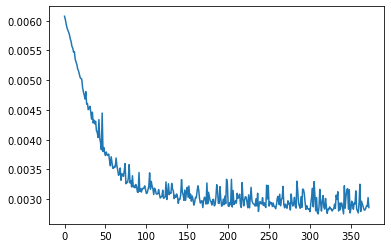

In [7]:
plt.plot(np.asarray(score_list)[20:])

tensor(0.9813, device='cuda:0', grad_fn=<MaxBackward1>)


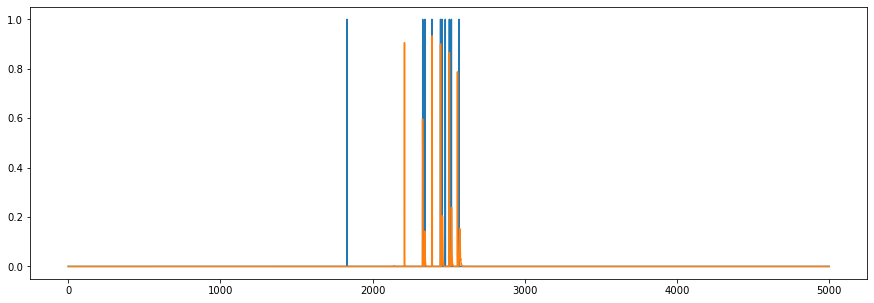

In [8]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy())
plt.plot(test_S_out[1].cpu().detach().numpy())
#plt.xlim(4500,5200)
#plt.ylim(-1,10)
print(torch.max(test_S_out))

In [9]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60_AP/whole_pred/gru_l20_h40_2ms.pt")
#np.save("/media/hdd01/sklee/CA1_clust4-60_AP/whole_pred/gru_l20_h40_2ms_test.npy", test_S_out.cpu().detach().numpy())